<a href="https://colab.research.google.com/github/tfrizza/DALL-E-tf/blob/main/MNIST_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tfrizza/DALL-E-tf.git

Cloning into 'DALL-E-tf'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 54 (delta 28), reused 30 (delta 13), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [2]:
%cd DALL-E-tf

/content/DALL-E-tf


In [3]:
import tensorflow as tf
from tensorflow.keras import Model, mixed_precision

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl

from dall_e_tf.encoder import dvae_encoder
from dall_e_tf.decoder import dvae_decoder
from dall_e_tf.utils import plot_reconstructions

mixed_precision.set_global_policy('mixed_float16')

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0
11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
vocab_size = 32
n_hid = 32

enc = dvae_encoder(img_size=28, group_count=3, n_hid=n_hid, n_blk_per_group=2, input_channels=x_train.shape[-1], vocab_size=vocab_size)
dec = dvae_decoder(img_size=7, group_count=3, n_init=n_hid//2, n_hid=n_hid, n_blk_per_group=2, output_channels=x_train.shape[-1], vocab_size=vocab_size)

def dVAE(enc, dec, temperature=1/16):
    z_e = enc.output # encoder logits

    z_q = tfpl.DistributionLambda(
        lambda logits: tfd.RelaxedOneHotCategorical(temperature, logits) # Gumbel-softmax
    )(z_e)

    z_hard = tf.math.argmax(z_e, axis=-1) # non-differentiable
    z_hard = tf.one_hot(z_hard, enc.output.shape[-1], dtype=tf.float16)

    z = z_q + tf.stop_gradient(z_hard - z_q) # straight-through Gumbel-softmax
    x_rec = dec(z)
    return Model(enc.input, x_rec)

vae = dVAE(enc, dec, 0.1)
vae.summary(line_length=200)

Model: "model_2"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_1 (InputLayer)                                              [(None, 28, 28, 1)]                         0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                                   (None, 28, 28, 32)                          1600                    input_1[0][0]                                

In [5]:
vae.compile(loss='mse', optimizer='adam')

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        epochs=1,
        batch_size=32,
        shuffle=True)

1875/1875 [==============================] - 41s 17ms/step - loss: 0.0331 - val_loss: 0.0094


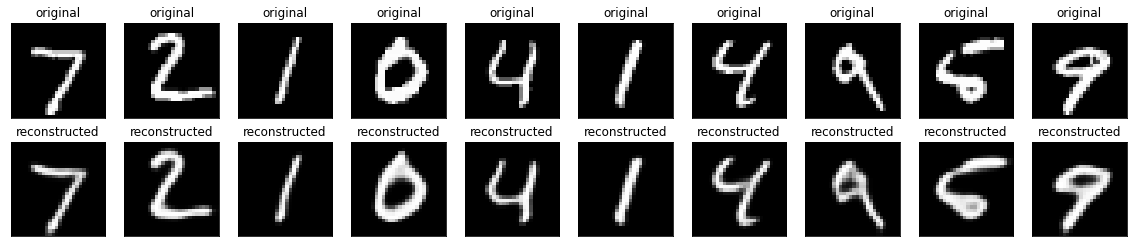

In [7]:
plot_reconstructions(vae(x_test[:10]), x_test[:10])